# Excess PKIN  Events

The CityIQ API for the San Diego system appears to be reporting excessive PKIN events, which, over about a month of records, results in a calculated excess of 80,000 cars in the San Diego system. For the dowtown neighborhood, the excess is about 1.8%; the PKIN and PKOUT records can be ballanced by reducing the number of PKIN records by 1.8%



In [1]:
import datetime
import statsmodels.formula.api as sm
from cityiq import Config, CityIq
from cityiq.scrape import EventScraper
tz = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo

In [2]:
f = '/Users/eric/proj/virt-proj/data-project/sdrdl-data-projects/sandiego.gov/predix.io/prod-credentials.yaml'
config = Config(f)

c = CityIq(config) # Maybe will need this later

# Scrape events from the API from Jan 1, 2019 to the current date, which is about Feb 9
start_time = datetime.datetime(2019, 1, 1, 0, 0, tzinfo = tz)
s = EventScraper(config, start_time,  ['PKIN', 'PKOUT'])

# We only need a few of the record values. 
from operator import itemgetter
keys = ['timestamp','locationUid', 'eventType']
ig = itemgetter(*keys)

parking_geo = pd.read_csv('parking_geo.csv')

df = pd.DataFrame( [ ig(e) for e in s.iterate_records()], 
                  columns=keys).sort_values('timestamp')

df = df.merge(parking_geo[['locationUid', 'geoid','community_name']], how='left', on='locationUid')


In [3]:
df['ts_rounded'] = (df.timestamp/1000).round(0).astype(int) # Quantize to 1 s
df['time'] =  pd.to_datetime(df.ts_rounded, unit = 's')

df['delta'] = df.eventType.apply(lambda v: 1 if v == 'PKIN' else -1)
df = df.sort_values('time')


In [4]:
print("""Number of Records: {:,}
Start Time       : {}
End Time         : {}""".format(len(df), df.time.min(), df.time.max()))

Number of Records: 9,250,990
Start Time       : 2019-01-01 08:00:01
End Time         : 2019-02-12 02:57:14


The source data has a lot of duplicate records, records of one event type, for one locationUid, which occur in batches within one second or so. These can be seen most notably as the large jumps on 16 Jan and 25 Jan, but there are many others, about 30,000 duplicate records in this period.  The plot below shows the cumlative number of cars in parking zones, where each PKIN increments the count and each PKOUT decrements the counts. We'd expect that the slope of this plot would be zero, but it is significantly increasing, indicating that there is an excess of PKIN records. 

In [5]:
dfcm = df.copy()
dfcm['cs'] = dfcm.delta.cumsum()
ax = dfcm.plot(x='time',y='cs', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nBefore de-duplication');

In [6]:
t = dfcm.delta.value_counts()
((t.iloc[0] - t.iloc[1])/t.iloc[0] * 100).round(2)

1.74

Removing these records eliminates the two large jumps and removes about 30,000 records, but the positive slope remains, because there are about 1.8% more PKIN events than PKOUT events. 

Deduplication by allowing only one event perlocation per 1 sec period. 


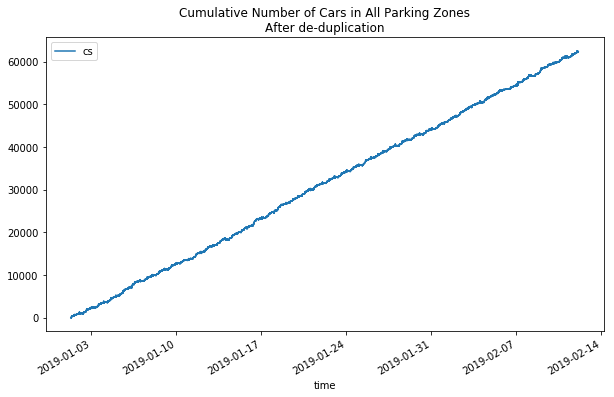

In [7]:
dfcm = df.copy().sort_values('timestamp')
dfcm['ts'] = dfcm.ts_rounded - dfcm.ts_rounded.iloc[0] # Seconds from start of dataset
dfcm = dfcm.sort_values(['time', 'eventType']).drop_duplicates(subset=['ts_rounded', 'eventType', 'locationUid'])
dfcm['cs'] = dfcm.delta.cumsum()

dedup1s = dfcm

ax = dfcm.plot(x='time',y='cs', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter de-duplication');

Here is the effect of de-duplication by taking only unique events per 4 minute period per location. There is still a very large excess of events at the end of the period

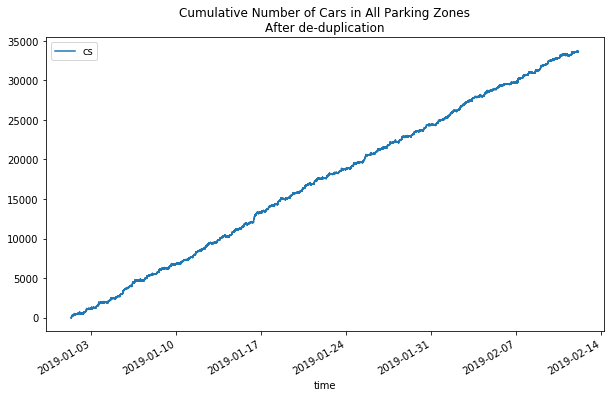

In [8]:
dfcm = df.copy().sort_values('timestamp')
dfcm['ts'] = dfcm.ts_rounded - dfcm.ts_rounded.iloc[0] # Seconds from start of dataset
dfcm['debounce_time'] = (dfcm.ts_rounded / 240).round(0).astype('int')

dfcm = dfcm.sort_values(['time', 'eventType']).drop_duplicates(subset=['debounce_time', 'eventType', 'locationUid'])
dfcm['cs'] = dfcm.delta.cumsum()

ax = dfcm.plot(x='time',y='cs', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter de-duplication');


Here is another de-bouncing technique. Per location, runs of a single event are numbered and the start time for the first event in the run is recorded. Revent are dropped of they are not the first event in a run and have a time difference from the first event of less than 4 minutes. The process starts with the data sets that was previously de-duplicated by quantizing to 1 sec periods. 

This de-duplication procedure operates per locationUid:

* Enumerate runs of events, where an event is the same type as the one before it
* Calculate the time difference each event in a run and the first event in the run
* Include only events that are either the first in the run, or more than 4 minute later than the first event in the run.


In [9]:
def rolling_count(val): # https://stackoverflow.com/a/25120837

    if val == rolling_count.previous:
        rolling_count.count +=1
    else:
        rolling_count.previous = val
        rolling_count.count = 1
    return rolling_count.count

def apply_rc(df):
    rolling_count.count = 0 #static variable
    rolling_count.previous = None #static variable
    df['rolling_count'] = df.delta.apply(rolling_count) #new column in dataframe


    df['run_st'] = df.apply(lambda r: r.ts_rounded if r.rolling_count == 1 else np.nan ,axis=1)\
                     .fillna(method='ffill')
    df['run_age'] = df.ts_rounded  - df.run_st 
    
    return df

In [10]:
# For 9M record set, using dedup1s rather than df drops the max rolling_count from 337 to 68
t = dedup1s.copy()
debncd = t.groupby('locationUid').apply(apply_rc)

In [87]:
excludes = debncd[(debncd.rolling_count > 1) & ( debncd.run_age <= 240)]
print(len(excludes))
excludes.eventType.value_counts()

1363030


PKIN     685223
PKOUT    677807
Name: eventType, dtype: int64

7416

9091158 7728128 1363030


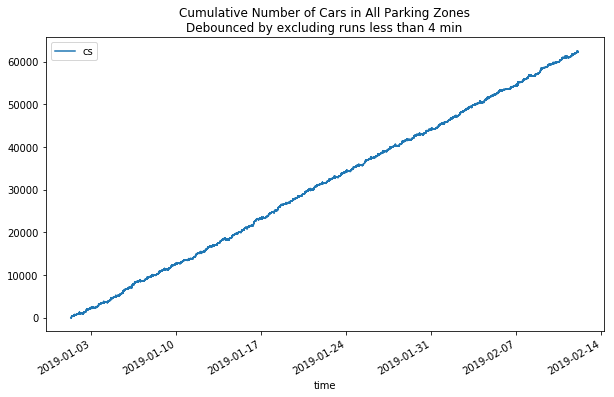

In [95]:
debncd['cs'] = debncd.delta.cumsum()
dedup_roll = debncd[(debncd.rolling_count == 1) | ( debncd.run_age > 240)]
dedup_roll 
ax = dedup_roll.plot(x='time',y='cs', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nDebounced by excluding runs less than 4 min');
print(len(debncd), len(dedup_roll), len(debncd) - len(dedup_roll))

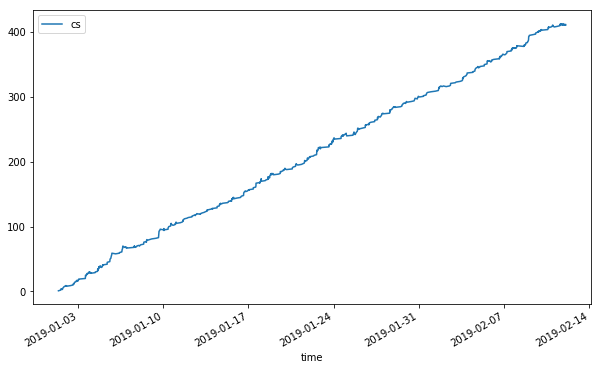

In [94]:
t = debncd[debncd.locationUid == '9ammc0pmfrqjkv54ve5'].copy()
t.to_csv('9ammc0pmfrqjkv54ve5.csv')
t = t[(t.rolling_count == 1) | ( t.run_age > 240)]
t['cs'] = t.delta.cumsum()

t.plot(x='time',y='cs', figsize = (10,6))

In [67]:
p='/Users/eric/proj/virt-proj/data-project/sdrdl-data-projects/sandiego.gov/sandiego.gov-cityiq_assets/notebooks/'\
  'locations.csv'
    
from rowgenerators import geoframe
locations = geoframe('file:'+p)
    

In [76]:
lset = ['zeskoshozxnjofxqbv8', '6qshsm9v7tijoa392lw', 'olpvp35ulnsjosxt134',
       '8fsy0n92ngjosxowd2', '9ammc0pmfrqjkv54ve5', 'tkgm8e2hcmjlcevd0h',
       's3zyz7cgjqojjixnsv2', 'we8u96pj9hqjoa10bqx', 'ukc6436b6fcjgzmdjee',
       'sqo8ib54vjot0ntck']
locations[locations.locationUid.isin(lset)].to_csv('locations.csv')

In [63]:
t = df[df.locationUid == '9ammc0pmfrqjkv54ve5'].copy()
t = t.groupby('locationUid').apply(apply_rc)
t.to_csv('9ammc0pmfrqjkv54ve5.csv')
t.head()

,timestamp,locationUid,eventType,geoid,community_name,ts_rounded,time,delta,rolling_count,run_st,run_age
7995,1546334478396,9ammc0pmfrqjkv54ve5,PKIN,14000US00000006937,Downtown,1546334478,2019-01-01 09:21:18,1,1,1.546334e+09,0.0
8033,1546334508301,9ammc0pmfrqjkv54ve5,PKIN,14000US00000006937,Downtown,1546334508,2019-01-01 09:21:48,1,2,1.546334e+09,30.0
32632,1546348979914,9ammc0pmfrqjkv54ve5,PKIN,14000US00000006937,Downtown,1546348980,2019-01-01 13:23:00,1,3,1.546334e+09,14502.0
41413,1546353770146,9ammc0pmfrqjkv54ve5,PKIN,14000US00000006937,Downtown,1546353770,2019-01-01 14:42:50,1,4,1.546334e+09,19292.0
41999,1546354052007,9ammc0pmfrqjkv54ve5,PKIN,14000US00000006937,Downtown,1546354052,2019-01-01 14:47:32,1,5,1.546334e+09,19574.0


In [46]:
debncd[debncd.locationUid == 'dpgruy45sejl3yxrcc'].sort_values('rolling_count', ascending = False).head()

,timestamp,locationUid,eventType,geoid,community_name,ts_rounded,time,delta,ts,cs,rolling_count,run_st,run_age
5329471,1548425467533,dpgruy45sejl3yxrcc,PKIN,14000US00000006940,Downtown,1548425468,2019-01-25 14:11:08,1,2095867,36500,15,1.548411e+09,14135.0
5323094,1548420712043,dpgruy45sejl3yxrcc,PKIN,14000US00000006940,Downtown,1548420712,2019-01-25 12:51:52,1,2091111,36326,14,1.548411e+09,9379.0
5320049,1548420274654,dpgruy45sejl3yxrcc,PKIN,14000US00000006940,Downtown,1548420275,2019-01-25 12:44:35,1,2090674,36285,13,1.548411e+09,8942.0
5318677,1548420027782,dpgruy45sejl3yxrcc,PKIN,14000US00000006940,Downtown,1548420028,2019-01-25 12:40:28,1,2090427,36256,12,1.548411e+09,8695.0
5316427,1548418860402,dpgruy45sejl3yxrcc,PKIN,14000US00000006940,Downtown,1548418860,2019-01-25 12:21:00,1,2089259,36177,11,1.548411e+09,7527.0


In [13]:

if False:
    t = df.copy()
    print('Start length: ', len(t))
    for i in range(4):
        t = t.groupby('locationUid').apply(apply_rc)
        t = t[~((t.rolling_count > 1) & (t.run_age > 60))]
        print("Iter {} length: {}".format(i, len(t)))

    debncd = t
    

In [14]:

debncd.rolling_count.max()

68

Another method to correct these errors is to compute the slope of the trend, then subtract it out. 

In [15]:

dfcm['ts'] = dfcm.ts_rounded - dfcm.ts_rounded.iloc[0] # Seconds from start of dataset
dfcm['C'] = 1
result = sm.ols(formula=" cs ~ ts + C", data=dfcm).fit()
print(result.params)



Intercept    1.457208
ts           0.009556
C            1.457208
dtype: float64


33618 8639.840999999988


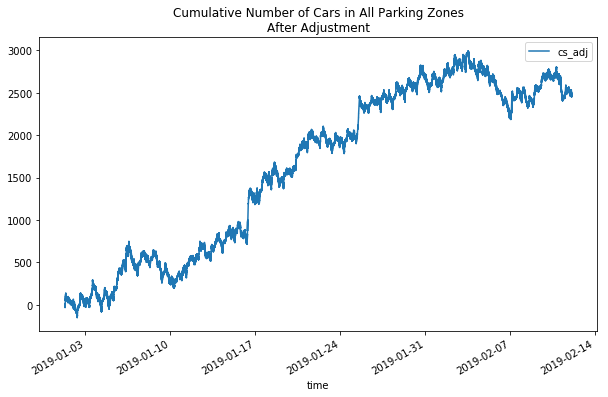

In [16]:

dfcm['C'] = 1
dfcm['rand'] = np.random.rand(dfcm.shape[0])
# The factor here, 0.013480 is based on the regression coeff above, then adjusted to make
# the oscilating parts of the plot mostly flat. 
dfcm['delta_adj'] = dfcm.delta.where( (dfcm.delta<0), 1-0.009)

dfcm['cs_adj'] = dfcm.delta_adj.cumsum()
print(dfcm.delta.sum(), dfcm.delta_adj.sum())

#ax =dfcm.plot(x ='ts', y='cs_adj', figsize = (10,6))
#ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');

t = dfcm[dfcm.community_name == 'Downtown'].copy()
t['cs_adj'] = t.delta_adj.cumsum()
ax = t.plot(x ='time', y='cs_adj', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');



In [17]:
dfcm[dfcm.community_name == 'Downtown'].delta.value_counts()

 1    1744190
-1    1726001
Name: delta, dtype: int64

In [18]:
t.cs_adj.min(),  t.cs_adj.max(), t.cs_adj.max()-t.cs_adj.min()

(-152.11800000000457, 2996.839999982789, 3148.9579999827934)

Parking events per neighborhood

In [19]:
dfcm.groupby('community_name').timestamp.count().sort_values(ascending=False).head(10)

community_name
Downtown                        3470191
Balboa Park                      462265
Uptown                           377152
Greater North Park               370655
Mid-City:Eastern Area            128731
College Area                      92504
Ocean Beach                       85384
Mid-City:Normal Heights           55625
Mid-City:Kensington-Talmadge      50086
Greater Golden Hill               45254
Name: timestamp, dtype: int64

Parking zones per neighborhood

In [20]:
dfcm.groupby('community_name').locationUid.nunique().sort_values(ascending=False).head(10)

community_name
Downtown                  545
Uptown                     96
Balboa Park                94
Greater North Park         79
Mid-City:Eastern Area      42
Skyline-Paradise Hills     31
Greater Golden Hill        19
College Area               18
Mira Mesa                  15
Ocean Beach                13
Name: locationUid, dtype: int64

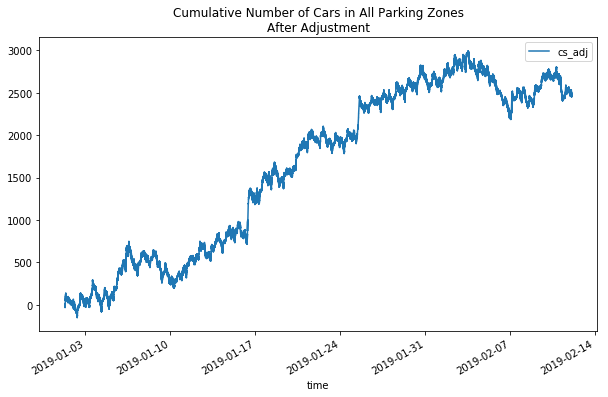

In [21]:
t = dfcm[dfcm.community_name == 'Downtown'].copy()
t['cs_adj'] = t.delta_adj.cumsum()
ax = t.plot(x ='time', y='cs_adj', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');


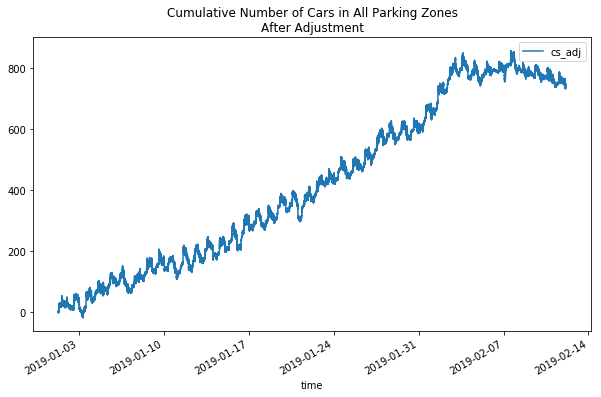

In [22]:
t = dfcm[dfcm.community_name == 'Uptown'].copy()
t['cs_adj'] = t.delta_adj.cumsum()
ax = t.plot(x ='time', y='cs_adj', figsize = (10,6))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter Adjustment');


In [23]:
dfcm[dfcm.community_name == 'Pacific Beach'].locationUid.nunique()

12

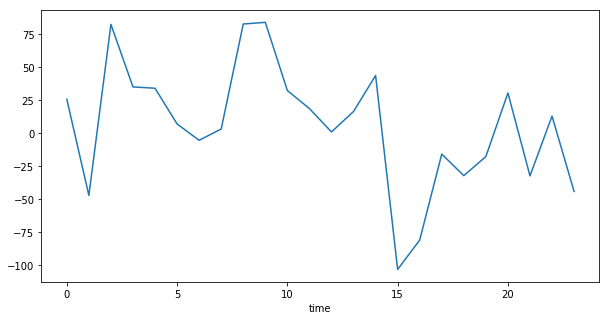

In [24]:
t = dfcm[dfcm.community_name == 'Ocean Beach']
t =t.groupby(t.time.dt.hour).delta_adj.sum()
t.plot(figsize=(10,5))

In [25]:
dfcm[dfcm.community_name == 'Uptown'].groupby('locationUid').count().eventType.sort_values(ascending=False).head()

locationUid
q3rkq130uhjiom604t     16264
tnu9csk2m3jiq0k60w     15702
wj89u8nssegjiq9vdzg    15314
upm6nl9cjb9jino89va    12817
ufgayo02zgrjipx2vm5    12266
Name: eventType, dtype: int64

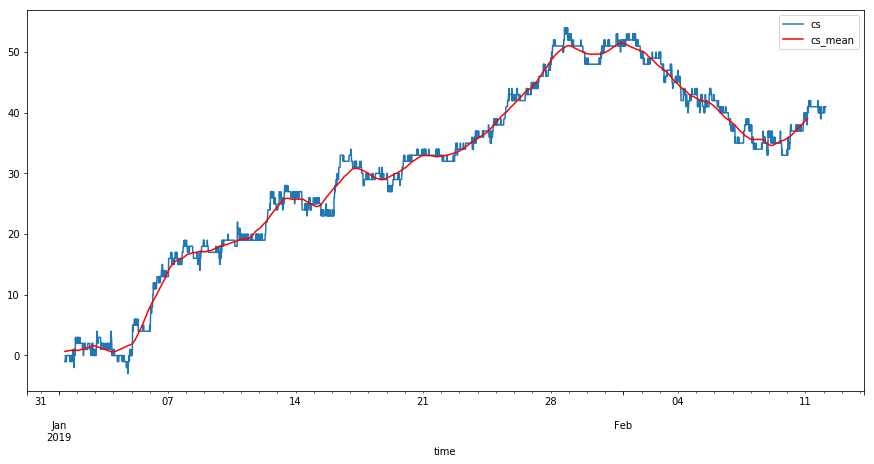

In [98]:
t = dedup_roll
t = t[t.locationUid == 'tnu9csk2m3jiq0k60w']
t = t.sort_values(['time', 'eventType']).drop_duplicates(subset=['time', 'eventType'])
t = t.sort_values('time').set_index('time').resample('15Min').sum()
t['cs'] = t.delta.cumsum()
t['cs_mean'] = t.cs.rolling('2d', closed='left').mean().shift(-24*4)


ax = t.plot(y='cs', figsize=(15, 7))
t.plot(ax=ax, y='cs_mean', color='red')

Note that there are a lot of large jumps, which happen most often around midnight

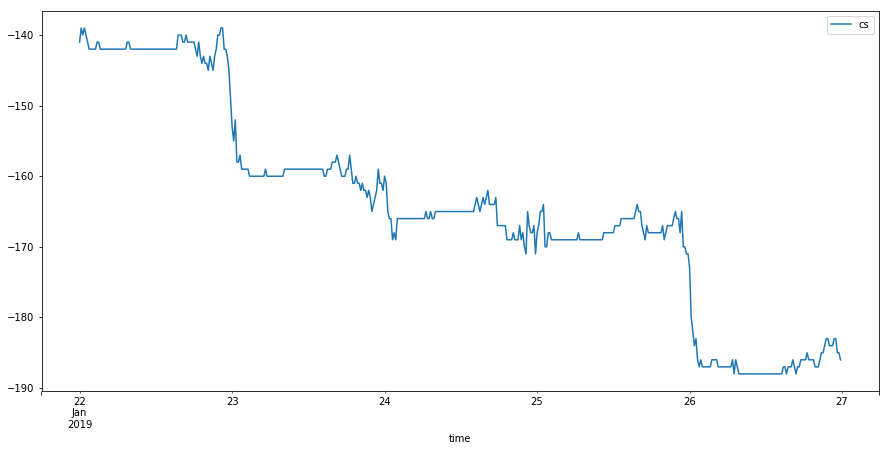

In [27]:
t.loc['2019-01-22':'2019-01-26'].plot(y='cs', figsize=(15, 7))

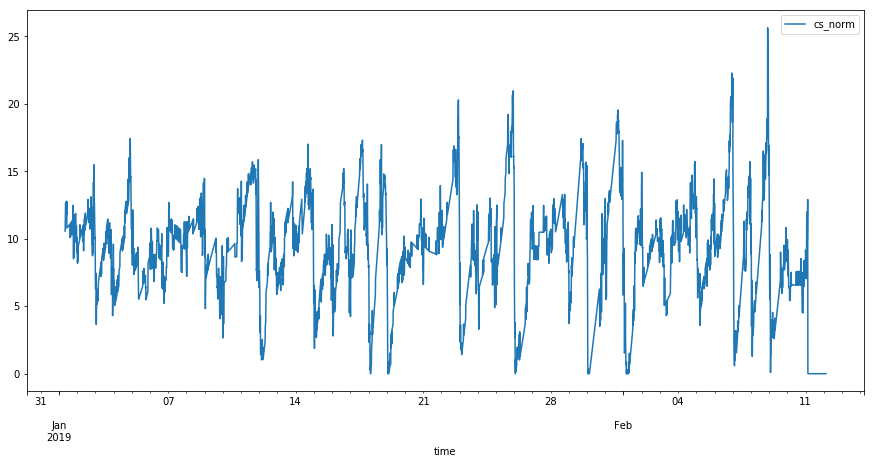

In [28]:
t['cs_norm'] = (t.cs - t.cs_mean) 
cs_min = t.groupby(pd.Grouper(freq='3D')).cs_norm.min().describe().loc['25%']
t['cs_norm'] = t.cs_norm - cs_min
t['cs_norm'] = t.cs_norm.where(t.cs_norm>0, 0 )
t.plot(y='cs_norm', figsize=(15, 7))

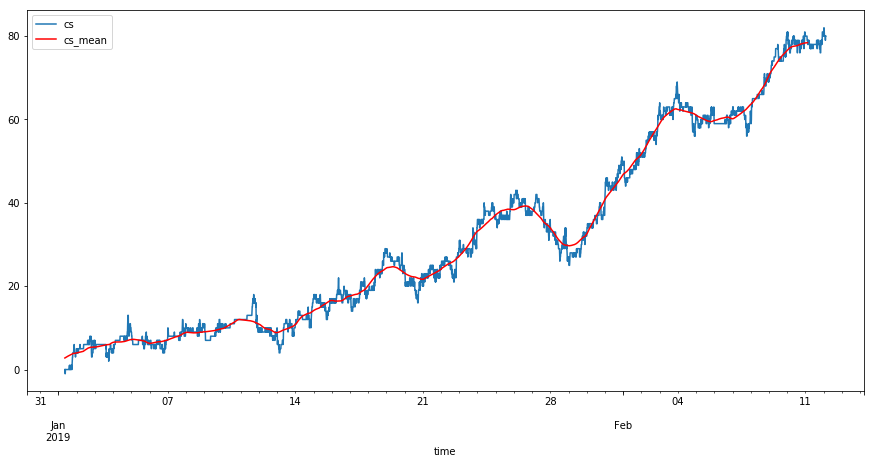

In [97]:
t = dedup_roll[dedup_roll.locationUid == 'wj89u8nssegjiq9vdzg']
t = t.sort_values(['time', 'eventType']).drop_duplicates(subset=['time', 'eventType'])
t = t.sort_values('time').set_index('time').resample('15Min').sum()
t['cs'] = t.delta.cumsum()
t['cs_mean'] = t.cs.rolling('2d', closed='left').mean().shift(-24*4)

ax = t.plot(y='cs', figsize=(15, 7))
t.plot(ax=ax, y='cs_mean', color='red')

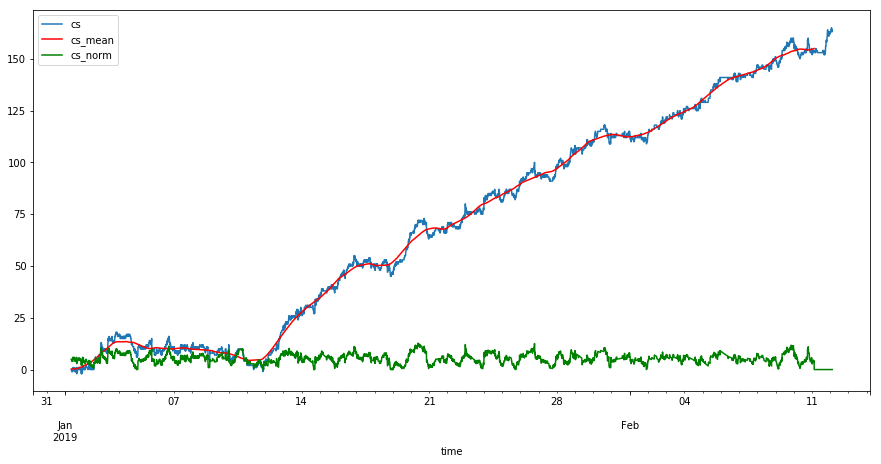

In [96]:


def re_norm_location(df):

    t = df.sort_values(['time', 'eventType'])\
         .drop_duplicates(subset=['time', 'eventType'])\
         .set_index('time')\
         .resample('15Min')\
         .sum()

    t['cs'] = t.delta.cumsum()
    
    # Find a two day rolling average
    t['cs_mean'] = t.cs.rolling('2d', closed='left').mean().shift(-24*4)

    # Substract off the mean. This makes the long term slope zero, like it should be
    t['cs_norm'] = (t.cs - t.cs_mean) 
    # The lowest value should be zero, but since it almost never is, we'll take the 25the percentile of 
    # the daily minimums as the zero point. 
    cs_min = t.groupby(pd.Grouper(freq='2D')).cs_norm.min().describe().loc['25%']

    # Sift the whole curve so the min value is zero. 
    t['cs_norm'] = t.cs_norm - cs_min
    
    # But, since we used the 25th percentile for the min, there are still some values that
    # are negative. Just truncate those. 
    t['cs_norm'] = t.cs_norm.where(t.cs_norm>0, 0 )

    
    # Put the deltas back on. We'll need them to aggregate multiple locatios together, 
    # becuase the cs_* field are only correct for this location. 
    t['cs_int'] = t.cs_norm.round(0).astype(int)
    t['delta'] = t.cs_int.diff().fillna(0).astype(int)
    
    return t

def plot_loc_norming(t):
    ax = t.plot(y='cs', figsize=(15, 7))
    t.plot(ax=ax, y='cs_mean', color='red')
    t.plot(ax=ax, y='cs_norm', color='green')
    
t = re_norm_location(dedup_roll[dedup_roll.locationUid == 'q3rkq130uhjiom604t'])
plot_loc_norming(t)

In [99]:
from tqdm import tqdm_notebook as tqdm
g = dedup_roll.groupby('locationUid')
locations = []
for gname, gframe in tqdm(g):
    #df = g.get_group(gname)
    t =  re_norm_location(gframe)
    t['locationUid'] = gname
    locations.append(t)

HBox(children=(IntProgress(value=0, max=1089), HTML(value='')))

In [100]:
len(locations)

1089

In [101]:
comb = pd.concat(locations)[['locationUid', 'delta']]

In [102]:
len(comb)

4192756

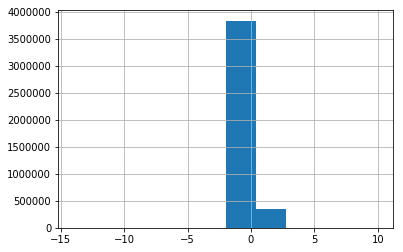

In [103]:
comb.delta.hist()

In [104]:
comb.head()

,locationUid,delta
time,,
2019-01-01 10:30:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 10:45:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 11:00:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 11:15:00,03e23a6ace01fc14a86ab250ce65b682,0
2019-01-01 11:30:00,03e23a6ace01fc14a86ab250ce65b682,0


In [105]:
t = comb.copy()
t.sort_index(inplace=True)
t['cs'] =  t.delta.cumsum()

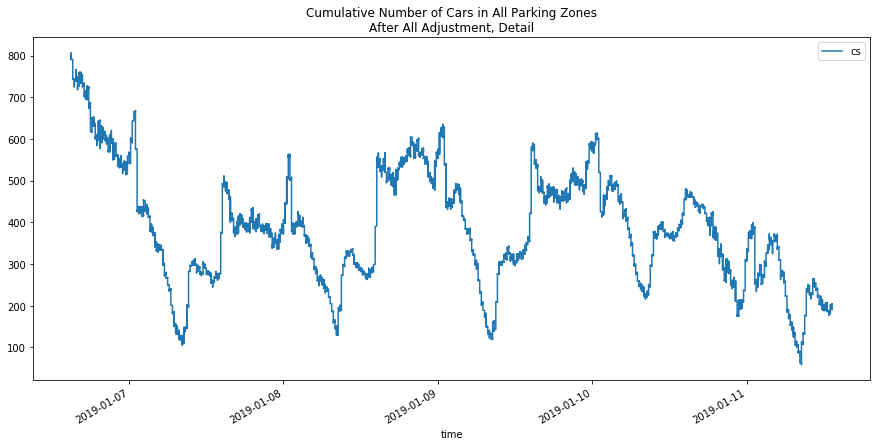

In [111]:
ax = t[t.cs > 0].iloc[500000:1000000].plot(y='cs', figsize=(15, 7))
ax.set_title('Cumulative Number of Cars in All Parking Zones\nAfter All Adjustment, Detail');

In [108]:
len(t)

4192756

In [41]:
comb.to_csv('events.csv')